In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

using Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [72]:
@autoadd begin
using Distributions
using StatsPlots
default(fmt=:png)
end

In [180]:
function wirehistogram3d(x::AbstractArray{T,1}, y::AbstractArray{T,1}; xlims::Tuple{Number,Number}=(0,0), ylims::Tuple{Number,Number}=(0,0), bins::Int64, kws...) where {T}

    # input check, if not given take extrema
    if all(xlims == (0,0))
        xlims = extrema(x)
    end
    if all(ylims == (0,0))
        ylims = extrema(y)
    end

    # create the x-y-grid to check values
    xgrid = range(xlims[1],xlims[end],length=bins+1)
    ygrid = range(ylims[1],ylims[end],length=bins+1)

    # count all x-y-values within a specific x-y-grid-cell (histcount may be nicer)
    z = [sum(all(((x[i],y[i]).>=(xgrid[itx],ygrid[ity])) .& ((x[i],y[i]).<(xgrid[itx+1],ygrid[ity+1]))) for i in eachindex(x)) for ity = 1:bins, itx = 1:bins]

    # Helpers for nice bars
    xdat = repeateps(xgrid,inner=(2));
    ydat = repeateps(ygrid,inner=(2));

    zdat = zeros(length(xdat),length(ydat));
    zdat[2:end-1,2:end-1] .= repeat(z,inner=(2,2));

    wireframe(xdat, ydat, zdat, xlims=xlims, ylims=ylims; kws...)
end

function histogram3d(x::AbstractArray{T,1}, y::AbstractArray{T,1}; xlims::Tuple{Number,Number}=(0,0), ylims::Tuple{Number,Number}=(0,0), bins::Int64, kws...) where {T}

    # input check, if not given take extrema
    if all(xlims == (0,0))
        xlims = extrema(x)
    end
    if all(ylims == (0,0))
        ylims = extrema(y)
    end

    # create the x-y-grid to check values
    xgrid = range(xlims[1],xlims[end],length=bins+1)
    ygrid = range(ylims[1],ylims[end],length=bins+1)

    # count all x-y-values within a specific x-y-grid-cell (histcount may be nicer)
    z = [sum(all(((x[i],y[i]).>=(xgrid[itx],ygrid[ity])) .& ((x[i],y[i]).<(xgrid[itx+1],ygrid[ity+1]))) for i in eachindex(x)) for ity = 1:bins, itx = 1:bins]

    # Helpers for nice bars
    xdat = repeateps(xgrid,inner=(2));
    ydat = repeateps(ygrid,inner=(2));

    zdat = zeros(length(xdat),length(ydat));
    zdat[2:end-1,2:end-1] .= repeat(z,inner=(2,2));
    
    @show size(xdat), size(ydat), size(zdat)

    surface(xdat, ydat, zdat, xlims=xlims, ylims=ylims; fill_z=[x for y in ydat, x in xdat], kws...)
    #surface(xdat, ydat, zdat, xlims=xlims, ylims=ylims; kws...)
end

repeateps(x;kws...) = repeat(x;kws...) .- [k%2 == 1 ? 1e-15 : 0 for k = 1:2*length(x)];

pyplot()

Plots.PyPlotBackend()

(size(xdat), size(ydat), size(zdat)) = ((42,), (42,), (42, 42))


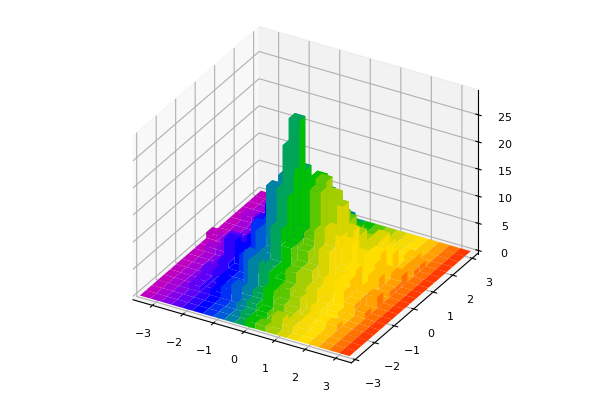

In [186]:
n = 1000
X, Y = randn(n), randn(n)
histogram3d(X, Y; bins=20, colorbar=false, c=:rainbow)

(size(xdat), size(ydat), size(zdat)) = ((42,), (42,), (42, 42))


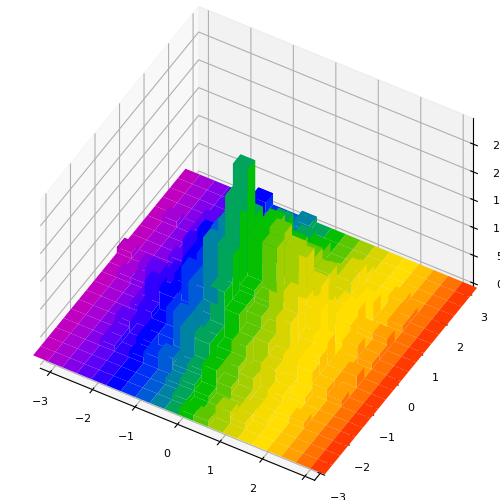

In [188]:
histogram3d(X, Y; xlim=(-3.1, 3.1), ylim=(-3.1, 3.1), bins=20, colorbar=false, camera=(30, 45), size=(500, 500), alpha=0.7, c=:rainbow)

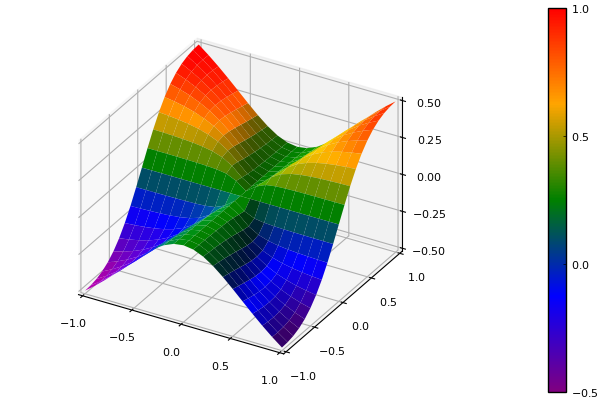

In [189]:
pyplot()
x, y = range(-1, 1, 21), range(-1, 1, 21)
f(x, y) = (x, y) == (0, 0) ? zero(x*y) : x^2*y/(x^2 + y^2)
surface(x, y, f.(x', y); fill_z = f.(x', y) .+ 0.5, c=:rainbow)

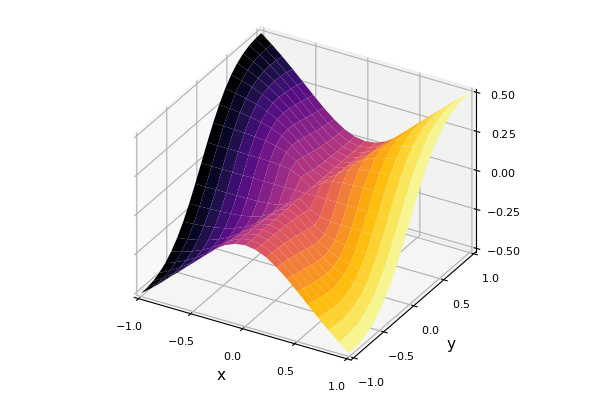

In [162]:
pyplot()
x, y = range(-1, 1, 21), range(-1, 1, 21)
f(x, y) = (x, y) == (0, 0) ? zero(x*y) : x^2*y/(x^2 + y^2)
surface(x, y, f.(x', y); fill_z = [x for y in y, x in x], colorbar=false)
plot!(xguide="x", yguide="y")

In [158]:
f.(x', y) .+ 0.5

21×21 Matrix{Float64}:
 0.0         0.0524862  0.109756  …  0.109756  0.0524862  0.0
 0.00276243  0.05       0.102759     0.102759  0.05       0.00276243
 0.0121951   0.0531034  0.1          0.1       0.0531034  0.0121951
 0.0302013   0.0638462  0.10354      0.10354   0.0638462  0.0302013
 0.0588235   0.0846154  0.116        0.116     0.0846154  0.0588235
 0.1         0.117925   0.140449  …  0.140449  0.117925   0.1
 0.155172    0.165979   0.18         0.18      0.165979   0.155172
 0.224771    0.23       0.236986     0.236986  0.23       0.224771
 0.307692    0.309412   0.311765     0.311765  0.309412   0.307692
 0.40099     0.40122    0.401538     0.401538  0.40122    0.40099
 0.5         0.5        0.5       …  0.5       0.5        0.5
 0.59901     0.59878    0.598462     0.598462  0.59878    0.59901
 0.692308    0.690588   0.688235     0.688235  0.690588   0.692308
 0.775229    0.77       0.763014     0.763014  0.77       0.775229
 0.844828    0.834021   0.82         0.82      0.83